# 140. User-Item based Collaborative Filtering - Matrix Factorization

## Keras로 MF(Matrix Factorization) 구현하기


### MF 방식의 원리

<img src="https://petamind.com/wp-content/uploads/2019/12/ml-mf-matrix-factorization-_op.svg" width=400 />

$$R \approx P\times Q^T=\hat{R}$$

R: Rating matrix, P: User latent matrix, Q: Item latent matrix, k: latent factor(잠재 요인), $\hat{R}$: 예측값

- R 행렬의 각 element는 해당 사용자 아이템에 대한 평점. 이 행렬은 사용자가 실제로 평가한 아이템에 대한 평점만을 가지고 있으므로 많은 원소가 null 로 채워진 sparse matrix 이다.
- R 행렬을 사용자 행렬 (P)와 아이템 행렬(Q)로 쪼개어 분석하는 방법이  MF  
- $\hat{R}$이 최대한 R에 가까운 값을 가지도록 하는 P와 Q를 구하면 그 것이 바로 추천을 위한 model이 된다.

$$\hat{r_{ij}}=b+bu_i + bd_j + \sum_{k=1}^k{p_{ik}q_{kj}}$$

$\hat{r_{ij}}$: 사용자 i 의 아이템 j 에  대한 예측값,  
b: 전체 평균. 일단 데이터가 주어지면 하나로 정해지는 값   
$bu_i$: 전체 평균을 제거한 후 사용자 i의 평가 경향(사용자 i의 평균과 전체 평균의 차이)     
$bd_j$: 전체 평균을 제거한 후 아이템 j의 평가 경향(아이템 j의 평균과 전체 평균의 차이)   
$p_{ik}$: 행렬 P의 i 번째 사용자 vector    
$q_{kj}$: 행렬 Q의 column j 번째 item vector

### MF 를 신경망으로 구현

<img src="https://ichi.pro/assets/images/max/724/1*VqQ5B6ah4KhbDKNBgX-cfg.png" />

- Input Layer 는 one-hot-encoding 과 같다. 
- Embedding Layer 는 latent factor d 에 해당.  
- 사용자와 아이템의 경향성(bias)을 feature 가 1 인  Embedding 으로 구현  
- 전체 평균(b)는 하나의 숫자이므로 신경망의 target value에서 일률적으로 빼 주고, 나중에 산출된 예측치에 일률적으로 더해주는 것이 전체 평균을 모델화 하는 것 보다 간단함.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten,  Concatenate, Dense

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('data/u.rating', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)            # timestamp 제거
ratings.head()

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [2]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('data/u.user', sep='|', names=u_cols, encoding='latin-1')
users = users[['user_id', 'age', 'sex', 'occupation']]
users['age'] /= users['age'].max()
users.head()

,user_id,age,sex,occupation
0,1,0.328767,M,technician
1,2,0.726027,F,other
2,3,0.315068,M,writer
3,4,0.328767,M,technician
4,5,0.452055,F,other


In [3]:
ratings = pd.merge(ratings, users, on='user_id')
ratings = pd.get_dummies(ratings)
ratings

,user_id,movie_id,rating,age,sex_F,sex_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,196,242,3,0.671233,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,196,393,4,0.671233,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,196,381,4,0.671233,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,196,251,3,0.671233,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,196,655,5,0.671233,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,941,919,5,0.273973,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
99996,941,273,3,0.273973,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
99997,941,1,5,0.273973,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
99998,941,294,4,0.273973,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
others_input_shape = ratings.iloc[:, 3:].values.shape[1]
others_input_shape

24

In [5]:
# train test set 분리
train_ratings, test_ratings = train_test_split(ratings, test_size=0.25, random_state=0)
train_ratings.shape, test_ratings.shape

((75000, 27), (25000, 27))

In [6]:
# Variable 초기화 
K = 100                             # Latent factor 수 
M = ratings.user_id.max() + 1       # Number of users - Embedding 이 0 부터 시작하므로 + 1
N = ratings.movie_id.max() + 1      # Number of movies

K, mu, M, N

(200, 0, 944, 1683)

In [7]:
Embedding(M, K)(1).shape

TensorShape([200])

### Shallow Neural Network
MF 구조 이해를 위해 hidden layer를 생략하고 Input, Embedding, Output Layer 로만 network 구성

In [8]:
# Keras model
user = Input(shape=(1, ), name="p_ik")                                               # User input
item = Input(shape=(1, ), name="q_kj")                                               # Item input
other_features = Input(shape=(others_input_shape,), name="other features")
P_embedding = Embedding(M, K, name="P")(user)        # (M,  K)
Q_embedding = Embedding(N, K, name="Q")(item)        # (N,  K)

user_bias = Embedding(M, 1, name="bu")(user)          # User bias term (M, 1)
item_bias = Embedding(N, 1, name="bd")(item)          # Item bias term (N, 1)

# Concatenate하기 위해 Embedding Layer들을 1차원으로 flatten
P_embedding = Flatten()(P_embedding)           #(K,)
Q_embedding = Flatten()(Q_embedding)          #(K,)
user_bias = Flatten()(user_bias)                      #(1,)
item_bias = Flatten()(item_bias)                      #(1,)

# 4개의 embedding layer들을 concatenate
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, other_features])   

# Hidden Layer로 연결
R = Dense(2048, activation='relu')(R)
R = Dense(256, activation='relu')(R)
R = Dense(64, activation='relu')(R)
R = Dense(1)(R)

# Model setting
model = Model(inputs=[user, item, other_features], outputs=R)

model.compile(
  loss="mse",
  optimizer="adam",
  metrics=["mse"]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 p_ik (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 q_kj (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 P (Embedding)                  (None, 1, 200)       188800      ['p_ik[0][0]']                   
                                                                                                  
 Q (Embedding)                  (None, 1, 200)       336600      ['q_kj[0][0]']                   
                                                                                              

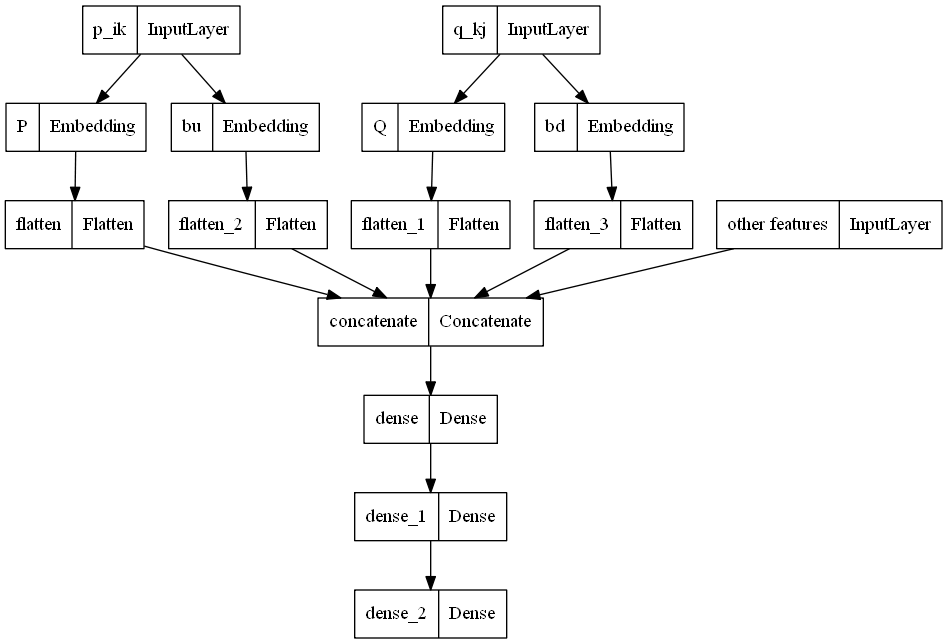

In [9]:
tf.keras.utils.plot_model(model)

In [10]:
test_ratings.iloc[:, 3:].values

array([[0.82191781, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.49315068, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.65753425, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.38356164, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.2739726 , 1.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.26027397, 0.        , 1.        , ..., 1.        , 0.        ,
        0.        ]])

In [11]:
# Model Train
history = model.fit(
    [train_ratings.user_id.values, train_ratings.movie_id.values, train_ratings.iloc[:, 3:].values],  #(user, item)
    train_ratings.rating.values,        #(target value - 평균)
  epochs=60,
  batch_size=256,
  validation_data=(
    [test_ratings.user_id.values, test_ratings.movie_id.values, test_ratings.iloc[:, 3:].values],
    test_ratings.rating.values
  )
)

Epoch 1/60
293/293 [==============================] - 4s 12ms/step - loss: 1.4717 - mse: 1.4717 - val_loss: 1.2391 - val_mse: 1.2391
Epoch 2/60
293/293 [==============================] - 3s 11ms/step - loss: 1.2221 - mse: 1.2221 - val_loss: 1.2214 - val_mse: 1.2214
Epoch 3/60
293/293 [==============================] - 4s 13ms/step - loss: 1.2023 - mse: 1.2023 - val_loss: 1.1975 - val_mse: 1.1975
Epoch 4/60
293/293 [==============================] - 4s 13ms/step - loss: 1.1774 - mse: 1.1774 - val_loss: 1.1695 - val_mse: 1.1695
Epoch 5/60
293/293 [==============================] - 4s 13ms/step - loss: 1.1422 - mse: 1.1422 - val_loss: 1.1333 - val_mse: 1.1333
Epoch 6/60
293/293 [==============================] - 4s 13ms/step - loss: 1.0944 - mse: 1.0944 - val_loss: 1.0790 - val_mse: 1.0790
Epoch 7/60
293/293 [==============================] - 4s 13ms/step - loss: 1.0373 - mse: 1.0373 - val_loss: 1.0247 - val_mse: 1.0247
Epoch 8/60
293/293 [==============================] - 4s 13ms/step - 

In [17]:
model.evaluate([test_ratings.user_id.values, test_ratings.movie_id.values,  test_ratings.iloc[:, 3:].values], test_ratings.rating.values)

782/782 [==============================] - 2s 2ms/step - loss: 0.8792 - mse: 0.8792


[0.8791715502738953, 0.8791715502738953]

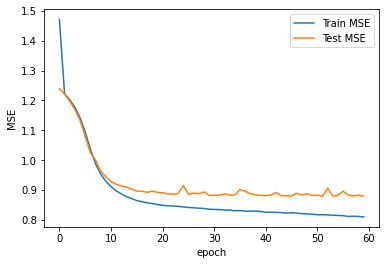

In [13]:
# Plot RMSE
plt.plot(history.history['mse'], label="Train MSE")
plt.plot(history.history['val_mse'], label="Test MSE")
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [16]:
# Test set에서 6개만 골라 Prediction 하여 비교
user_ids = test_ratings.user_id.values[0:6]
movie_ids = test_ratings.movie_id.values[0:6]
occupations = test_ratings.iloc[:, 3:].values[0:6]
predictions = model.predict([user_ids, movie_ids, occupations])
print("Actuals: \n", test_ratings.rating.values[0:6])
print( )
print("Predictions: \n", predictions)

Actuals: 
 [4 4 1 4 3 5]

Predictions: 
 [[3.1898432]
 [3.2675529]
 [3.1697202]
 [4.251382 ]
 [2.989102 ]
 [4.374737 ]]


In [15]:
# Test set 전체의 mse 계산
user_ids = test_ratings.user_id.values
movie_ids = test_ratings.movie_id.values
occupations = test_ratings.iloc[:, 3:].values

y_pred = model.predict([user_ids, movie_ids, occupations])
y_true = test_ratings.rating.values

mean_squared_error(y_true, y_pred, squared=True)

0.8791706401617957